## Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

In [20]:
#  About dataset 

dataset_dir      = 'SYNOP/origine/data'               
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)


scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
iterations       = 4
sequence_len     = 16
batch_size       = 32
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [3]:
# Read dataset 

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

#  Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
print('Train dataset example :')
display(dataset_train.head(15))

# Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

print('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

print('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


Train dataset example :


,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


After normalization :


,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


Shapes :
Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


In [4]:
# Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# About

print('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)


About the splitting of our dataset :
Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


## LSTM model

In [5]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               45200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


In [6]:
run_dir='SYNOP/origine/run'

save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [7]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

In [8]:
history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

Epoch 1/10
729/729 [==============================] - 16s 20ms/step - loss: 0.6091 - mae: 0.5124 - val_loss: 0.4827 - val_mae: 0.4224
Epoch 2/10
729/729 [==============================] - 14s 20ms/step - loss: 0.5032 - mae: 0.4386 - val_loss: 0.4622 - val_mae: 0.4098
Epoch 3/10
729/729 [==============================] - 14s 20ms/step - loss: 0.4799 - mae: 0.4198 - val_loss: 0.4489 - val_mae: 0.3975
Epoch 4/10
729/729 [==============================] - 15s 20ms/step - loss: 0.4673 - mae: 0.4086 - val_loss: 0.4398 - val_mae: 0.3933
Epoch 5/10
729/729 [==============================] - 15s 20ms/step - loss: 0.4577 - mae: 0.4021 - val_loss: 0.4308 - val_mae: 0.3756
Epoch 6/10
729/729 [==============================] - 8s 11ms/step - loss: 0.4483 - mae: 0.3962 - val_loss: 0.4330 - val_mae: 0.3777
Epoch 7/10
729/729 [==============================] - 6s 9ms/step - loss: 0.4432 - mae: 0.3920 - val_loss: 0.4258 - val_mae: 0.3628
Epoch 8/10
729/729 [==============================] - 7s 9ms/step

In [9]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

## Plot the predictions

In [15]:
def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            save_as='auto', time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # Real sequence without prediction
        
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # What we expect
        
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1
    plt.show()

1/1 [==============================] - 0s 15ms/step


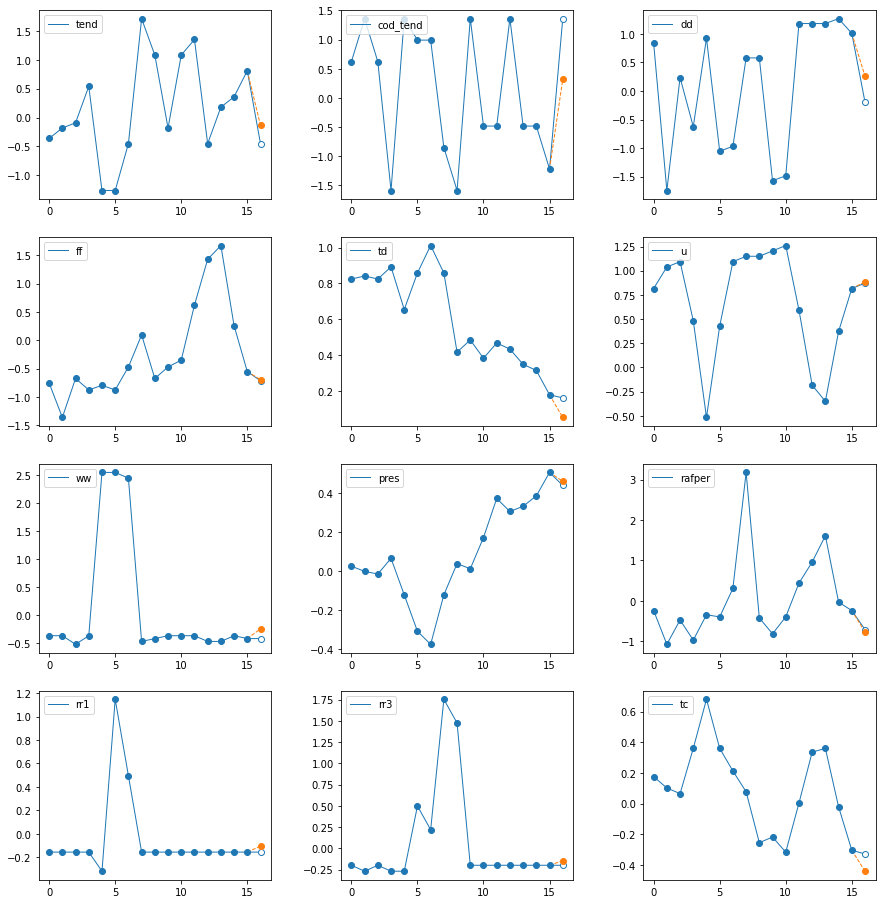

In [17]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# Show result
plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


1/1 [==============================] - 0s 17ms/step


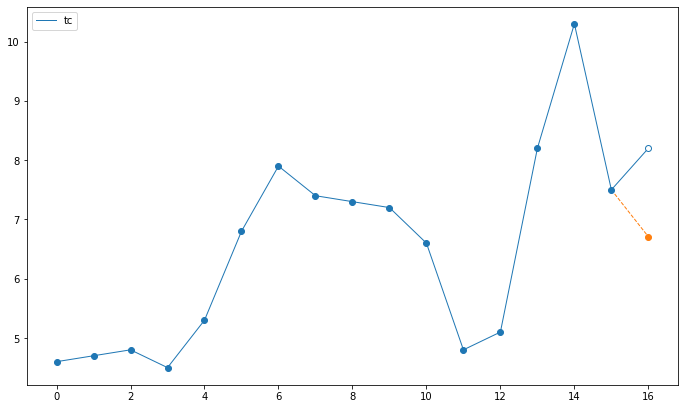

Gap between prediction and reality : 1.49 °C


In [18]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# Prediction

pred = loaded_model.predict( np.array([sequence]) )

# De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# Show it
feat=11

plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


1/1 [==============================] - 0s 17ms/step


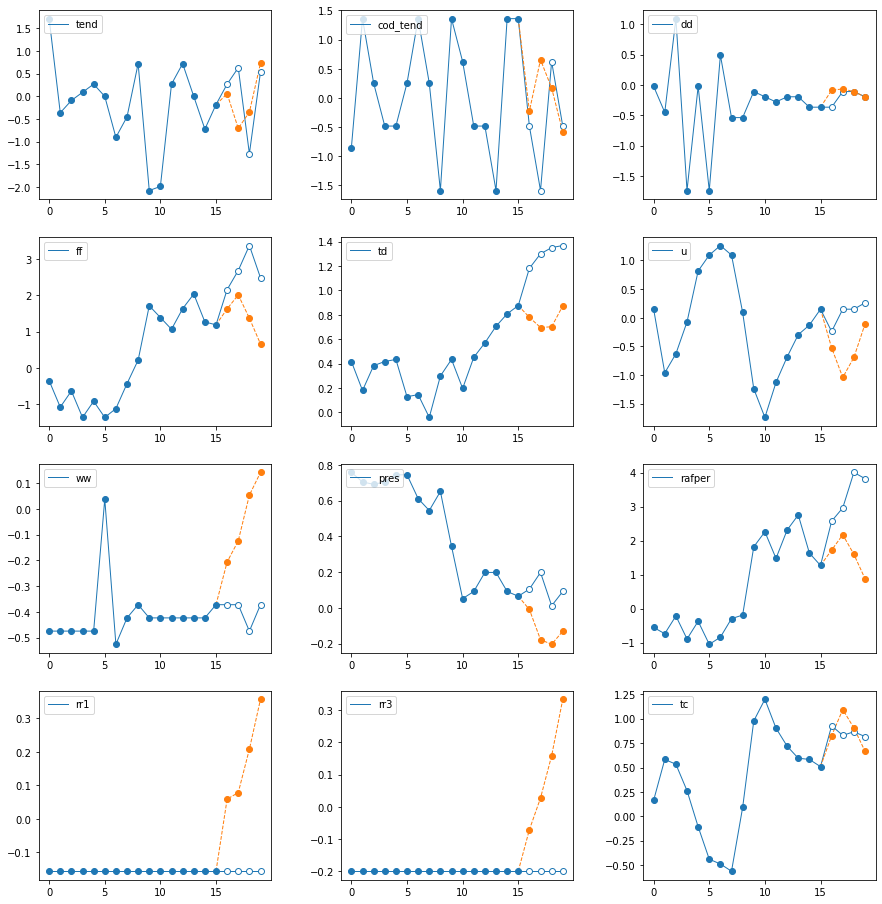

In [21]:
# Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# Iterate on 4 predictions

sequence_pred=list(sequence_pred)

for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# Show result

plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='01-prediction-norm')


In [22]:
def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

1/1 [==============================] - 0s 16ms/step


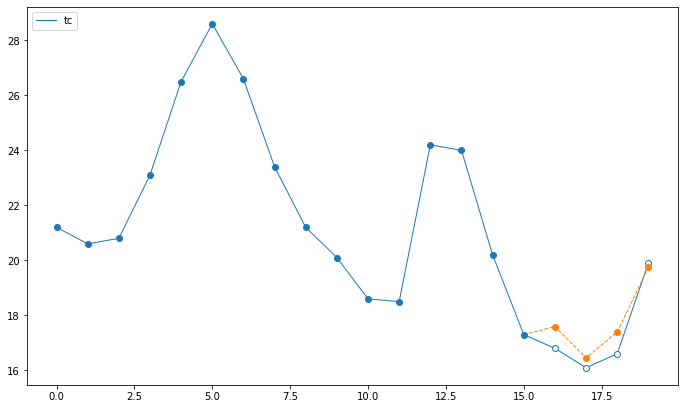

In [23]:
sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=4)

feat=11

plot_multivariate_serie(sequence_true, predictions=pred, labels=features,
                            only_features=[feat],width=14, height=8, save_as='02-prediction')